In [3]:
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerTuple
import matplotlib.lines as mlines
import pandas as pd
import os

import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

Searching for TensorBoard files...
Found 3 TensorBoard files:
  - /home/olympus/tyyang99/weaver-core-dev/weaver/runs/Aug29_17-23-30_farm221_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1.000/events.out.tfevents.1756459410.farm221.161889.0
  - /home/olympus/tyyang99/weaver-core-dev/weaver/runs/May10_10-20-11_farm221_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.000/events.out.tfevents.1746843611.farm221.3888.0
  - /home/olympus/tyyang99/weaver-core-dev/weaver/runs/Aug25_21-30-05_farm221_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2.000/events.out.tfevents.1756128605.farm221.3007.0

Reading: /home/olympus/tyyang99/weaver-core-dev/weaver/runs/Aug29_17-23-30_farm221_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1.000/events.out.tfevents.1756459410.farm221.161889.0
Data shape: (560, 5)
Metrics included: ['Loss/train (epoch)', 'Acc/train (epoch)', 'lr/train (e

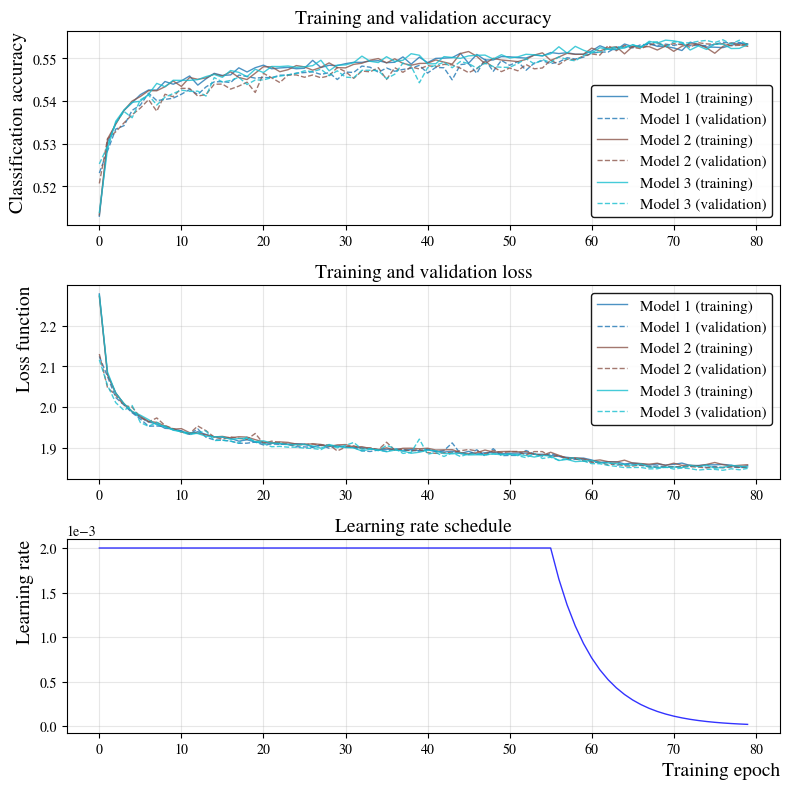

In [4]:
def read_tensorboard_data(log_path):
    """Read TensorBoard data"""
    ea = EventAccumulator(log_path)
    ea.Reload()
    
    # Get all scalar data
    scalar_tags = ea.Tags()['scalars']
    
    data = []
    for tag in scalar_tags:
        scalar_events = ea.Scalars(tag)
        for event in scalar_events:
            data.append({
                'tag': tag,
                'step': event.step,
                'value': event.value,
                'wall_time': event.wall_time
            })
    
    return pd.DataFrame(data)

def find_tensorboard_files(base_path):
    """Find all TensorBoard files matching the pattern"""
    pattern = os.path.join(base_path, "*_farm221_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3*.000")
    folders = glob.glob(pattern)
    
    tb_files = []
    for folder in folders:
        # Find tfevents files in each folder
        tfevents_pattern = os.path.join(folder, "events.out.tfevents.*")
        tfevents_files = glob.glob(tfevents_pattern)
        if tfevents_files:
            tb_files.append(tfevents_files[0])  # Take the first file
    
    return tb_files

def extract_epoch_from_step(df, steps_per_epoch=None):
    """Convert step to epoch"""
    if steps_per_epoch is None:
        # Try to automatically estimate steps per epoch
        # Assume steps are continuous, find the maximum step difference as estimate
        steps = sorted(df['step'].unique())
        if len(steps) > 1:
            steps_per_epoch = max(np.diff(steps))
        else:
            steps_per_epoch = 1
    
    df['epoch'] = df['step'] / steps_per_epoch
    return df

def plot_combined_metrics(all_data):
    """Plot combined three subplots"""
    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_data)))
    
    # First subplot: Accuracy
    ax1 = axes[0]
    for i, (file_path, df) in enumerate(all_data.items()):
        model_name = f'Model {i+1}'
        
        train_tags = [tag for tag in df['tag'].unique() if 'acc' in tag.lower() and ('train' in tag.lower() or 'training' in tag.lower())]
        eval_tags = [tag for tag in df['tag'].unique() if 'acc' in tag.lower() and ('eval' in tag.lower() or 'val' in tag.lower() or 'test' in tag.lower())]
        
        color = colors[i]
        
        # Plot training curves (solid line)
        for j, tag in enumerate(train_tags):
            tag_data = df[df['tag'] == tag].sort_values('step')
            if not tag_data.empty:
                label = f'{model_name} (training)' if j == 0 else None
                ax1.plot(tag_data['epoch'], tag_data['value'], 
                        color=color, linestyle='-', linewidth=1, 
                        label=label, alpha=0.8)
        
        # Plot validation curves (dashed line)
        for j, tag in enumerate(eval_tags):
            tag_data = df[df['tag'] == tag].sort_values('step')
            if not tag_data.empty:
                label = f'{model_name} (validation)' if j == 0 else None
                ax1.plot(tag_data['epoch'], tag_data['value'], 
                        color=color, linestyle='--', linewidth=1, 
                        label=label, alpha=0.8)
    
    ax1.set_ylabel('Classification accuracy', ha='right', y=1.0, fontsize=14)
    ax1.set_title('Training and validation accuracy', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best',framealpha=0.9, edgecolor='black',fontsize=11)
    
    # Second subplot: Loss
    ax2 = axes[1]
    for i, (file_path, df) in enumerate(all_data.items()):
        model_name = f'Model {i+1}'
        
        train_tags = [tag for tag in df['tag'].unique() if 'loss' in tag.lower() and ('train' in tag.lower() or 'training' in tag.lower())]
        eval_tags = [tag for tag in df['tag'].unique() if 'loss' in tag.lower() and ('eval' in tag.lower() or 'val' in tag.lower() or 'test' in tag.lower())]
        
        color = colors[i]
        
        # Plot training curves (solid line)
        for j, tag in enumerate(train_tags):
            tag_data = df[df['tag'] == tag].sort_values('step')
            if not tag_data.empty:
                label = f'{model_name} (training)' if j == 0 else None
                ax2.plot(tag_data['epoch'], tag_data['value'], 
                        color=color, linestyle='-', linewidth=1, 
                        label=label, alpha=0.8)
        
        # Plot validation curves (dashed line)
        for j, tag in enumerate(eval_tags):
            tag_data = df[df['tag'] == tag].sort_values('step')
            if not tag_data.empty:
                label = f'{model_name} (validation)' if j == 0 else None
                ax2.plot(tag_data['epoch'], tag_data['value'], 
                        color=color, linestyle='--', linewidth=1, 
                        label=label, alpha=0.8)
    
    ax2.set_ylabel('Loss function', ha='right', y=1.0, fontsize=14)
    ax2.set_title('Training and validation loss', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best',framealpha=0.9, edgecolor='black',fontsize=11)
    
    # Third subplot: Learning Rate
    ax3 = axes[2]
    first_file = list(all_data.keys())[0]
    df = all_data[first_file]
    
    lr_tags = [tag for tag in df['tag'].unique() if 'lr' in tag.lower() or 'learning_rate' in tag.lower()]
    
    if lr_tags:
        lr_tag = lr_tags[0]
        lr_data = df[df['tag'] == lr_tag].sort_values('step')
        
        if not lr_data.empty:
            ax3.plot(lr_data['epoch'], lr_data['value'], 
                     color='blue', linestyle='-', linewidth=1, alpha=0.8)
    else:
        print("No learning rate related tags found!")
    
    ax3.set_xlabel('Training epoch', ha='right', x=1.0, fontsize=14)
    ax3.set_ylabel('Learning rate', ha='right', y=1.0, fontsize=14)
    ax3.set_title('Learning rate schedule', fontsize=14)
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()

# Main program
def main():
    # Set base path
    base_path = "/home/olympus/tyyang99/weaver-core-dev/weaver/runs"
    
    print("Searching for TensorBoard files...")
    tb_files = find_tensorboard_files(base_path)
    
    if not tb_files:
        print("No matching TensorBoard files found!")
        return
    
    print(f"Found {len(tb_files)} TensorBoard files:")
    for file in tb_files:
        print(f"  - {file}")
    
    # Read all data
    all_data = {}
    for tb_file in tb_files:
        print(f"\nReading: {tb_file}")
        try:
            df = read_tensorboard_data(tb_file)
            df = extract_epoch_from_step(df)
            all_data[tb_file] = df
            
            print(f"Data shape: {df.shape}")
            print(f"Metrics included: {list(df['tag'].unique())}")
            
        except Exception as e:
            print(f"Error reading file {tb_file}: {e}")
    
    if not all_data:
        print("No data successfully read!")
        return
    
    # Plot combined figure
    print("\nPlotting combined figure...")
    plot_combined_metrics(all_data)
    plt.savefig('PLOTS/combined_training_metrics.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('PLOTS/combined_training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()
